In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import DataLoader, random_split
import torchvision
import torchvision.transforms as transforms
from torchvision import models

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

print("Torch:", torch.__version__)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Reproducibility (not perfect on GPU, but helps)
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)


Torch: 2.9.0+cu126
Device: cuda


# **Part 1: Training a CNN from Scratch with CIFAR-10 dataset**


In [2]:
#CIFAR-10 - mean and std
import torch
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

dataset = CIFAR10(root="./data", train=True, download=True, transform=transforms.ToTensor())
loader = DataLoader(dataset, batch_size=50000)

data = next(iter(loader))[0]  # solo imágenes

mean = data.mean(dim=[0,2,3])
std  = data.std(dim=[0,2,3])

print("Mean:", mean)
print("Std:", std)

Mean: tensor([0.4914, 0.4822, 0.4465])
Std: tensor([0.2470, 0.2435, 0.2616])


In [3]:
# CIFAR-10 normalization stats
cifar10_mean = (0.4914, 0.4822, 0.4465)
cifar10_std  = (0.2470, 0.2435, 0.2616)

train_tfms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize(cifar10_mean, cifar10_std),
])

test_tfms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(cifar10_mean, cifar10_std),
])

train_full = torchvision.datasets.CIFAR10(root="./data", train=True, download=True, transform=train_tfms)
test_set   = torchvision.datasets.CIFAR10(root="./data", train=False, download=True, transform=test_tfms)

# Split train into train/val
val_size = 5000
train_size = len(train_full) - val_size
train_set, val_set = random_split(train_full, [train_size, val_size])

batch_size = 128
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True,  num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_set,   batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_set,  batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

classes = train_full.classes
print("Classes:", classes)
print("Train/Val/Test:", len(train_set), len(val_set), len(test_set))


Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Train/Val/Test: 45000 5000 10000


In [4]:
#CNN model

class SimpleCIFAR10CNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()

        self.features = nn.Sequential(
            # Block 1: 3x32x32 -> 32x32x32 -> 32x16x16
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            # Block 2: 32x16x16 -> 64x16x16 -> 64x8x8
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            # Block 3: 64x8x8 -> 128x8x8 -> 128x4x4
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
        )

        self.classifier = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(128 * 4 * 4, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)  # flatten to vector
        x = self.classifier(x)
        return x

cnn_model = SimpleCIFAR10CNN(num_classes=10).to(device)
print(cnn_model)


SimpleCIFAR10CNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.3, inplace=False)
    (1): Linear(in_features=2048, out_features=256, bi

In [5]:
#Train/val loops + tracking loss/accuracy
#Backprop + optimizer is the same training loop idea you used in earlier assignments, just with CNN layers.

def accuracy_from_logits(logits, y):
    preds = logits.argmax(dim=1)
    return (preds == y).float().mean().item()

def run_epoch(model, loader, optimizer=None):
    is_train = optimizer is not None
    model.train() if is_train else model.eval()

    total_loss = 0.0
    total_acc = 0.0
    n_batches = 0

    criterion = nn.CrossEntropyLoss()

    for x, y in loader:
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)

        if is_train:
            optimizer.zero_grad(set_to_none=True)

        with torch.set_grad_enabled(is_train):
            logits = model(x)
            loss = criterion(logits, y)

            if is_train:
                loss.backward()
                optimizer.step()

        total_loss += loss.item()
        total_acc  += accuracy_from_logits(logits, y)
        n_batches += 1

    return total_loss / n_batches, total_acc / n_batches

# Train CNN
epochs = 20
optimizer = optim.Adam(cnn_model.parameters(), lr=0.001)

history = {
    "train_loss": [], "train_acc": [],
    "val_loss": [],   "val_acc": []
}

best_val_acc = 0.0
best_state = None

for epoch in range(1, epochs + 1):
    train_loss, train_acc = run_epoch(cnn_model, train_loader, optimizer=optimizer)
    val_loss, val_acc     = run_epoch(cnn_model, val_loader,   optimizer=None)

    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_state = {k: v.cpu().clone() for k, v in cnn_model.state_dict().items()}

    print(f"Epoch {epoch:02d}/{epochs} | "
          f"train loss {train_loss:.4f} acc {train_acc:.4f} | "
          f"val loss {val_loss:.4f} acc {val_acc:.4f}")

# Load best validation checkpoint
cnn_model.load_state_dict(best_state)
print("Best val acc:", best_val_acc)


Epoch 01/20 | train loss 1.5263 acc 0.4363 | val loss 1.2342 acc 0.5469
Epoch 02/20 | train loss 1.1979 acc 0.5688 | val loss 1.0667 acc 0.6162
Epoch 03/20 | train loss 1.0670 acc 0.6183 | val loss 0.9802 acc 0.6357
Epoch 04/20 | train loss 0.9984 acc 0.6451 | val loss 0.8808 acc 0.6896
Epoch 05/20 | train loss 0.9442 acc 0.6648 | val loss 0.8638 acc 0.6900
Epoch 06/20 | train loss 0.9042 acc 0.6814 | val loss 0.8438 acc 0.7041
Epoch 07/20 | train loss 0.8694 acc 0.6923 | val loss 0.7889 acc 0.7279
Epoch 08/20 | train loss 0.8425 acc 0.7054 | val loss 0.8155 acc 0.7199
Epoch 09/20 | train loss 0.8152 acc 0.7122 | val loss 0.7730 acc 0.7318
Epoch 10/20 | train loss 0.7933 acc 0.7246 | val loss 0.7169 acc 0.7598
Epoch 11/20 | train loss 0.7716 acc 0.7299 | val loss 0.6890 acc 0.7596
Epoch 12/20 | train loss 0.7516 acc 0.7382 | val loss 0.8431 acc 0.7072
Epoch 13/20 | train loss 0.7358 acc 0.7427 | val loss 0.6826 acc 0.7639
Epoch 14/20 | train loss 0.7230 acc 0.7486 | val loss 0.6547 acc

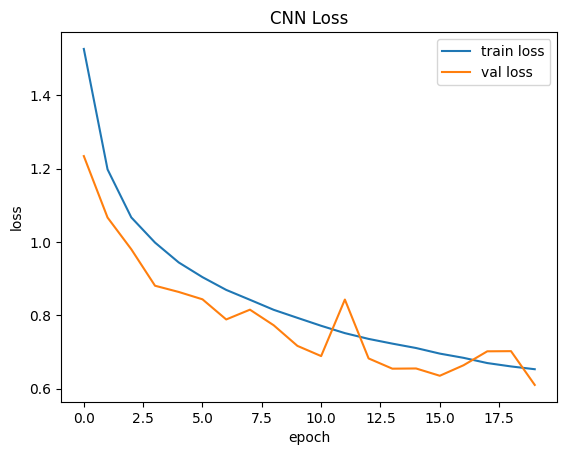

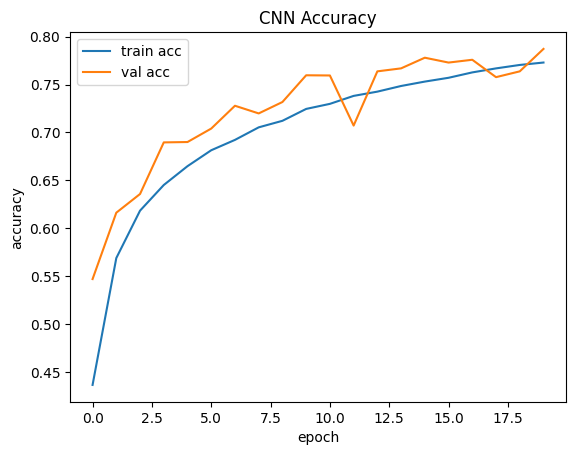

In [6]:
#Plot training curves (loss + accuracy) for CNN
plt.figure()
plt.plot(history["train_loss"], label="train loss")
plt.plot(history["val_loss"], label="val loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.title("CNN Loss")
plt.show()

plt.figure()
plt.plot(history["train_acc"], label="train acc")
plt.plot(history["val_acc"], label="val acc")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend()
plt.title("CNN Accuracy")
plt.show()


Evaluate CNN on test set (final accuracy)
test_loss, test_acc = run_epoch(cnn_model, test_loader, optimizer=None)
print(f"CNN Test Accuracy: {test_acc:.4f} | Test Loss: {test_loss:.4f}")


# **Part 2: Transfer Learning with ResNet-18**

In [7]:
#ResNet input pipeline

imagenet_mean = (0.485, 0.456, 0.406)
imagenet_std  = (0.229, 0.224, 0.225)

tl_train_tfms = transforms.Compose([
    transforms.Resize(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std),
])

tl_test_tfms = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std),
])

tl_train_full = torchvision.datasets.CIFAR10(root="./data", train=True, download=True, transform=tl_train_tfms)
tl_test_set   = torchvision.datasets.CIFAR10(root="./data", train=False, download=True, transform=tl_test_tfms)

# Split train/val again
tl_val_size = 5000
tl_train_size = len(tl_train_full) - tl_val_size
tl_train_set, tl_val_set = random_split(tl_train_full, [tl_train_size, tl_val_size])

tl_train_loader = DataLoader(tl_train_set, batch_size=64, shuffle=True,  num_workers=2, pin_memory=True)
tl_val_loader   = DataLoader(tl_val_set,   batch_size=64, shuffle=False, num_workers=2, pin_memory=True)
tl_test_loader  = DataLoader(tl_test_set,  batch_size=64, shuffle=False, num_workers=2, pin_memory=True)


In [8]:
#Load ResNet-18, replace final layer, freeze backbone
resnet = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
# Replace last layer for CIFAR-10 (10 classes)
resnet.fc = nn.Linear(resnet.fc.in_features, 10)

# Freeze everything except the final layer (feature extraction)
for name, param in resnet.named_parameters():
    param.requires_grad = False
for param in resnet.fc.parameters():
    param.requires_grad = True

resnet = resnet.to(device)
print(resnet.fc)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 205MB/s]

Linear(in_features=512, out_features=10, bias=True)


In [9]:
#Train only the final layer, then report test accuracy
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet.fc.parameters(), lr=0.001)

def eval_accuracy(model, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device, non_blocking=True)
            y = y.to(device, non_blocking=True)
            logits = model(x)
            preds = logits.argmax(dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)
    return correct / total

tl_epochs = 10
best_val = 0.0
best_state = None

for epoch in range(1, tl_epochs + 1):
    resnet.train()
    pbar = tqdm(tl_train_loader, desc=f"TL Epoch {epoch}/{tl_epochs}")
    for x, y in pbar:
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)
        logits = resnet(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        pbar.set_postfix(loss=float(loss.item()))

    val_acc = eval_accuracy(resnet, tl_val_loader)
    print(f"Val accuracy: {val_acc:.4f}")

    if val_acc > best_val:
        best_val = val_acc
        best_state = {k: v.cpu().clone() for k, v in resnet.state_dict().items()}

resnet.load_state_dict(best_state)
test_acc_resnet = eval_accuracy(resnet, tl_test_loader)
print(f"ResNet-18 Transfer Learning Test Accuracy: {test_acc_resnet:.4f}")


TL Epoch 1/10: 100%|██████████| 704/704 [01:25<00:00,  8.20it/s, loss=0.359]


Val accuracy: 0.7866


TL Epoch 2/10: 100%|██████████| 704/704 [01:26<00:00,  8.16it/s, loss=0.608]


Val accuracy: 0.8034


TL Epoch 3/10: 100%|██████████| 704/704 [01:26<00:00,  8.15it/s, loss=0.632]


Val accuracy: 0.7968


TL Epoch 4/10: 100%|██████████| 704/704 [01:26<00:00,  8.13it/s, loss=1.15]


Val accuracy: 0.7996


TL Epoch 5/10: 100%|██████████| 704/704 [01:25<00:00,  8.20it/s, loss=0.578]


Val accuracy: 0.8006


TL Epoch 6/10: 100%|██████████| 704/704 [01:25<00:00,  8.24it/s, loss=0.405]


Val accuracy: 0.8044


TL Epoch 7/10: 100%|██████████| 704/704 [01:25<00:00,  8.21it/s, loss=0.817]


Val accuracy: 0.8124


TL Epoch 8/10: 100%|██████████| 704/704 [01:26<00:00,  8.12it/s, loss=0.691]


Val accuracy: 0.8128


TL Epoch 9/10: 100%|██████████| 704/704 [01:27<00:00,  8.08it/s, loss=1.24]


Val accuracy: 0.8094


TL Epoch 10/10: 100%|██████████| 704/704 [01:26<00:00,  8.18it/s, loss=0.377]


Val accuracy: 0.8076
ResNet-18 Transfer Learning Test Accuracy: 0.8085
